In [25]:
# %load jupyter_default.py
import pandas as pd
import numpy as np
import os
import re
import datetime
import time
import glob
from tqdm import tqdm_notebook
from colorama import Fore, Style

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

%config InlineBackend.figure_format='retina'
sns.set() # Revert to matplotlib defaults
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelpad'] = 20
plt.rcParams['legend.fancybox'] = True
plt.style.use('ggplot')

SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 14, 16, 20
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)

def savefig(plt, name):
    plt.savefig(f'../figures/{name}.png', bbox_inches='tight', dpi=300)

from IPython.display import HTML
HTML('<style>div.text_cell_render{font-size:130%;}</style>')

In [2]:
%reload_ext version_information
%version_information pandas, numpy

Software versions
Python 3.6.8 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 7.2.0
OS Darwin 18.2.0 x86_64 i386 64bit
pandas 0.23.4
numpy 1.15.4
Sat Mar 02 13:25:06 2019 PST

# Goalie Pull Bayes Optimize

 - Solve for the posterior probabilties at time t:    
$
P(\text{goal for}|\text{goalie pulled}; t)\\
P(\text{goal against}|\text{goalie pulled}; t)
$

The idea is to figure out the **risk reward of pulling a goalie as a function of:**
 - **t = Time remaining in the game.** For instance, if there's 3 minutes left, what is the chance that pulling the goalie will result in a goal for? What is the probability it will result in a goal against?
 - **t = Time since goalie pull.** For instance, after the goalie has been pulled for 1 minute, what is the chance of seeing a goal for or goal against?
 
We'll model these independently.

Another complication is that games can end without either team scoring. To handle this we could correct our calculated posteriors based on the fraction of games that end this way. Or, better yet, we can calculate $P(\text{game end}|\text{goalie pulled}; t)$ in our model as well.

## Train Bayesian Model

We can model $P(t)$ using a discrete **poisson distribution i.e. if modeling the probability by second. We could also assume a Gamma posterior for the continuous case.**

We'll solve for this posterior distribution computationally using markov chain monte carlo and the `pymc3` library. 

Ideally we could use a **uniform prior over the domain of times (last 5mins)**. Note: this is OK since we throw out goalie pulls greater than 5 minutes from the end of the game (due to high likelihood of false positives when parsing goalie pulls from the raw game table).

In [11]:
from typing import List
import pymc3 as pm

### Load the training data

In [12]:
def load_data():
    files = glob.glob('../data/pkl/*.pkl')
    files = sorted(files)
    print(files)
    return pd.concat((pd.read_pickle(f) for f in files))

def clean_df(df):
    _df = df.copy()
    
    len_0 = _df.shape[0]
    print('Removing goal_for_time < 15 mins')
    _df = _df[~(_df.goal_for_time < datetime.timedelta(seconds=15*60))]
    print(f'Removed {len_0 - _df.shape[0]} total rows')
    
    if 'game_end_time' in df.columns:
        len_0 = _df.shape[0]
        print('Removing game_end_time < 15 mins')
        _df = _df[~(_df.game_end_time < datetime.timedelta(seconds=60*15))]
        print(f'Removed {len_0 - _df.shape[0]} total rows')

    return _df

In [13]:
df = load_data()
df = clean_df(df)

['../data/pkl/20032004_goalie_pulls_2019-03-01.pkl', '../data/pkl/20052006_goalie_pulls_2019-03-01.pkl', '../data/pkl/20062007_goalie_pulls_2019-03-01.pkl']
Removing goal_for_time < 15 mins
Removed 1 total rows


### Rough work

#### Data loading

In [14]:
def load_training_samples(df, cols, dtype='timedelta64[s]') -> np.ndarray:
    '''
    Return buckets of training data.
    '''
    out = []
    for col in cols:
        d = df[col].dropna().astype(dtype).values
        out.append(d)
        print(f'Loaded {len(d)} samples for col {col}')
        
        
    out = np.array(out)
    print(f'shape = {out.shape}')
    return out

Let's start by modeling the 5 on 6 goal times in 3rd period, where time is a continuous (or rather, discretized by second) and measured in minutes.

In [15]:
features = ['goal_for_time', 'goal_against_time']
training_samples = load_training_samples(df, features)

Loaded 270 samples for col goal_for_time
Loaded 554 samples for col goal_against_time
shape = (2,)


In [16]:
training_samples[0].shape

(270,)

In [17]:
training_samples[0][:10]

array([1180., 1124., 1157., 1168., 1118., 1183., 1130., 1116., 1172.,
       1181.])

To get the proper probabilities, we should weight the 

#### Modeling

In [18]:
# with pm.Model() as model:
#     prior_goal_for = pm.Uniform('prior_goal_for', 15, 20)
#     prior_goal_against = pm.Uniform('prior_goal_against', 15, 20)
#     obs_goal_for = pm.Gamma('obs_goal_for', observed=training_samples[0])

# need to set up priors for all the parameters of the gamma!...
# THINK ABOUT IT

In [43]:
def bayes_model(training_samples):
    
    with pm.Model() as model:

        # Posteriors for the mu parameter of the poisson distribution
        # Note that mu = mean(Poisson)
        mu_goal_for = pm.Uniform('mu_goal_for', 15*60, 20*60)
        mu_goal_against = pm.Uniform('mu_goal_against', 15*60, 20*60)

        # Observations
        obs_goal_for = pm.Poisson('obs_goal_for', mu_goal_for, observed=training_samples[0])
        obs_goal_against = pm.Poisson('obs_goal_against', mu_goal_against, observed=training_samples[1])
        
        # Posteriors for the goal probabilities
        p_goal_for = pm.Poisson('p_goal_for', mu_goal_for)
        p_goal_against = pm.Poisson('p_goal_against', mu_goal_against)

        # Fit model
        step = pm.Metropolis()
        trace = pm.sample(18000, step=step)
        
    return model, trace

# N = 10
# test_training_samples = np.array([training_samples[0][:N],
#                                   training_samples[1][:N]])
# model, trace, burned_trace = bayes_model(test_training_samples)
# model

In [45]:
model, trace = bayes_model(training_samples)
model

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_goal_against]
>Metropolis: [p_goal_for]
>Metropolis: [mu_goal_against]
>Metropolis: [mu_goal_for]
Sampling 4 chains: 100%|██████████| 74000/74000 [00:18<00:00, 3984.24draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [46]:
N_burn = 10000
burned_trace = trace[N_burn:]

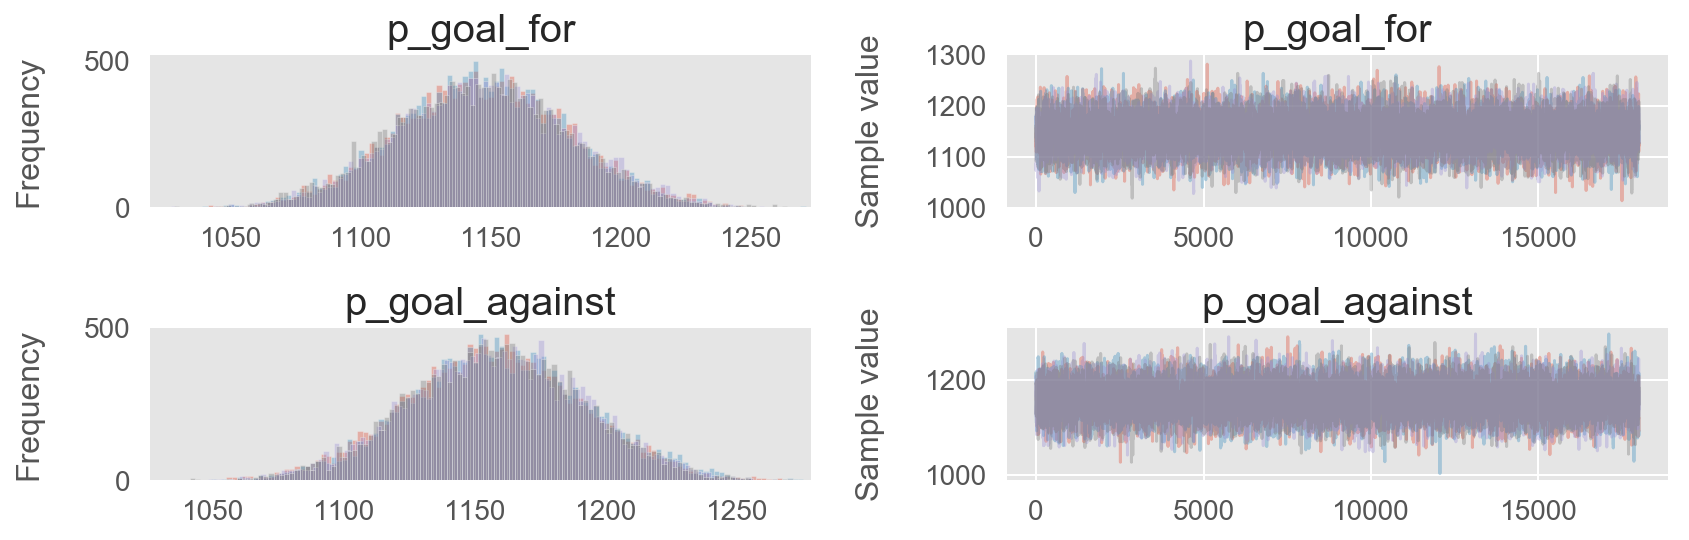

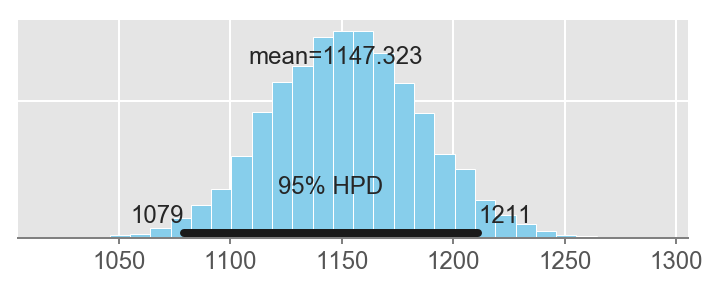

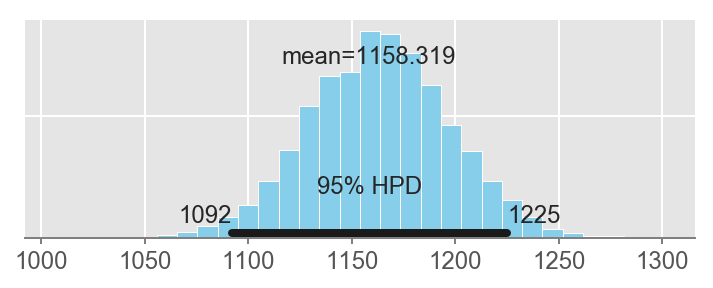

In [51]:
pm.plots.traceplot(trace=trace, varnames=['p_goal_for', 'p_goal_against'])
pm.plots.plot_posterior(trace=trace['p_goal_for'])
pm.plots.plot_posterior(trace=trace['p_goal_against'])

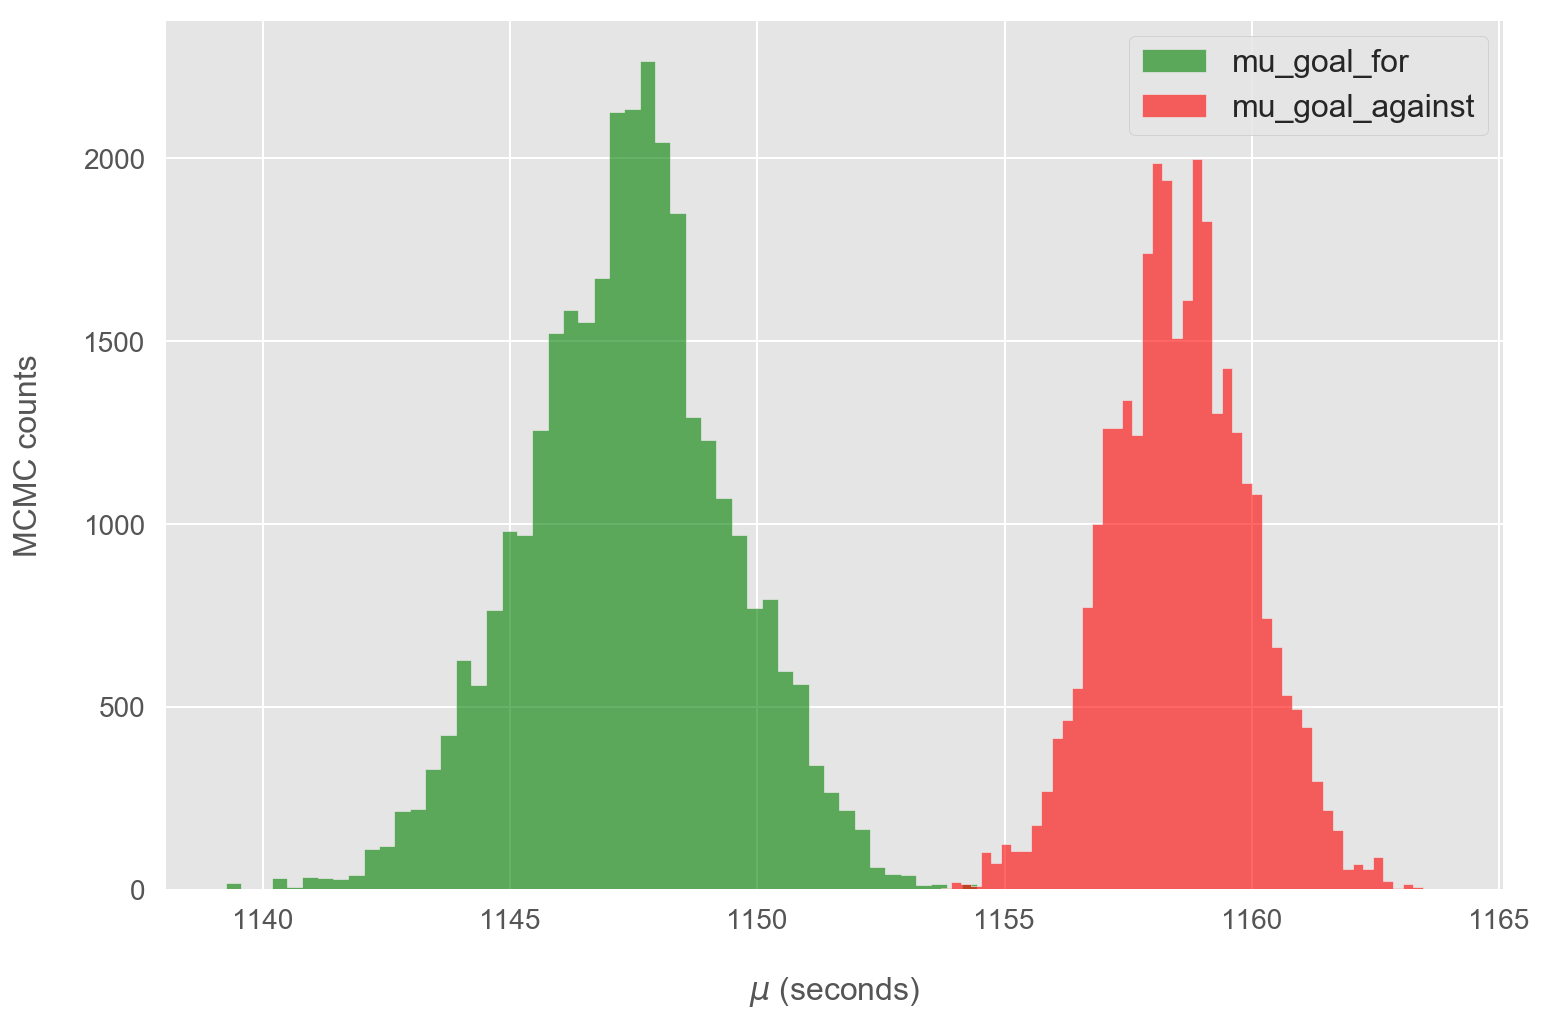

In [52]:
ALPHA = 0.6

plt.hist(burned_trace['mu_goal_for'], bins=50,
         color='green', label='mu_goal_for',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['mu_goal_against'], bins=50,
         color='red', label='mu_goal_against',
         histtype='stepfilled', alpha=ALPHA)
plt.ylabel('MCMC counts')
plt.xlabel('$\mu$ (seconds)')
plt.legend();

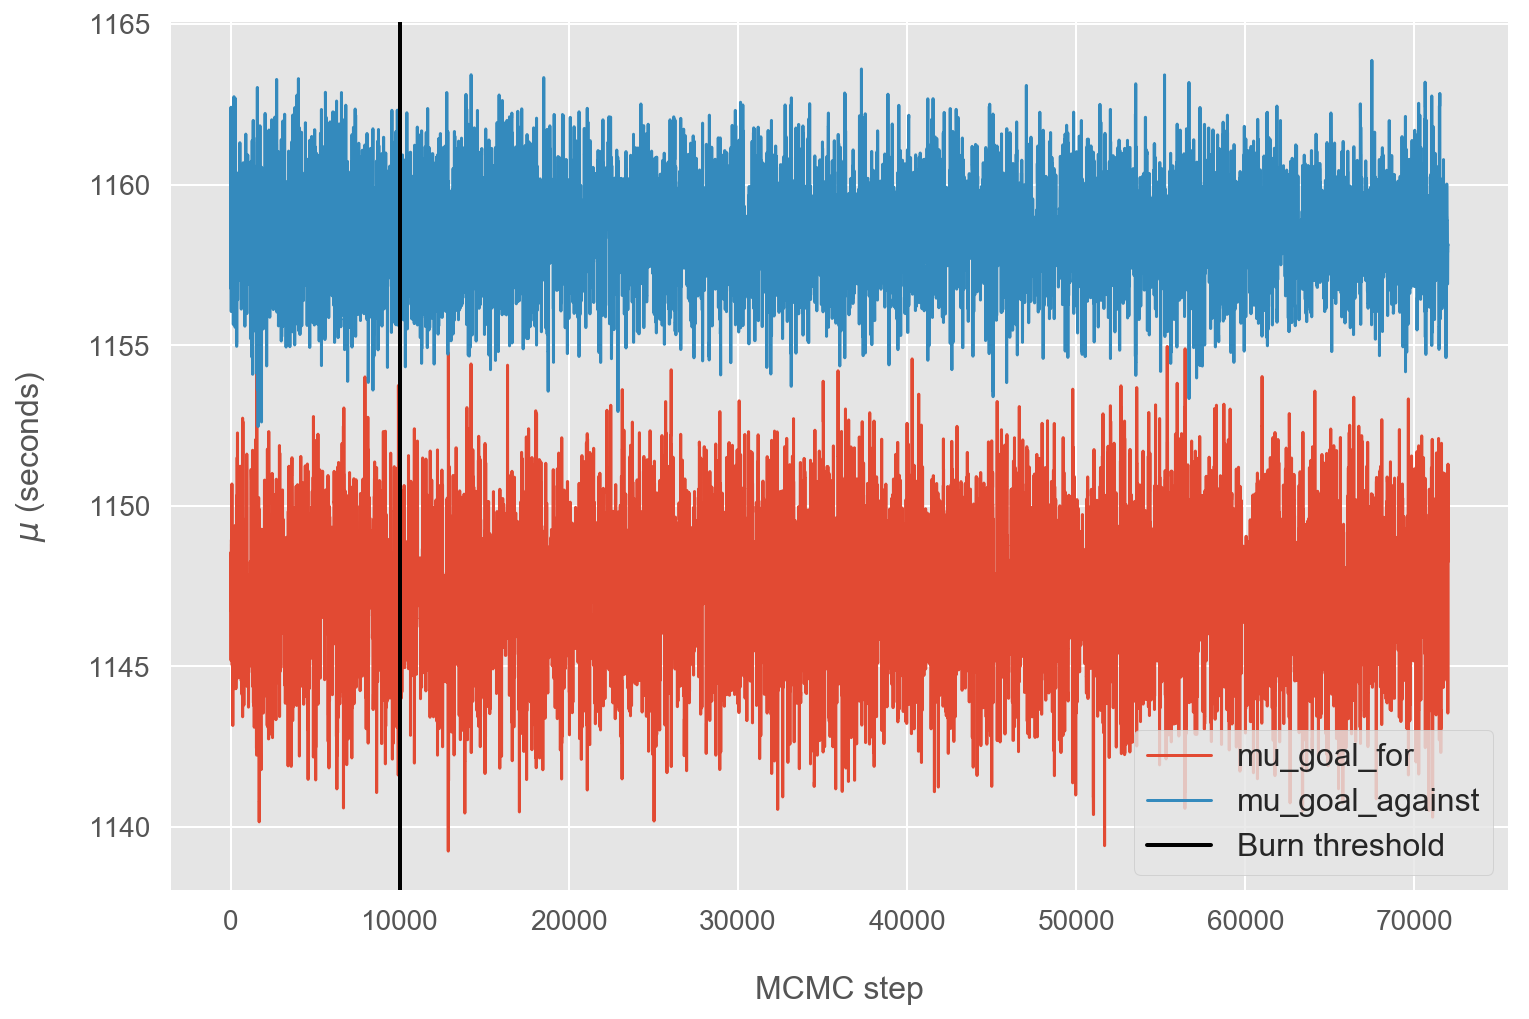

In [48]:
plt.plot(trace['mu_goal_for'], label='mu_goal_for')
plt.plot(trace['mu_goal_against'], label='mu_goal_against')
plt.ylabel('$\mu$ (seconds)')
plt.xlabel('MCMC step')

plt.axvline(N_burn, color='black', lw=2, label='Burn threshold')

plt.legend();

In [55]:
from scipy.special import factorial
poisson = lambda mu, k: mu**k * np.exp(-mu) / factorial(k)
poisson(0.5, np.array([1, 4, 5, 2]))

array([3.03265330e-01, 1.57950693e-03, 1.57950693e-04, 7.58163325e-02])

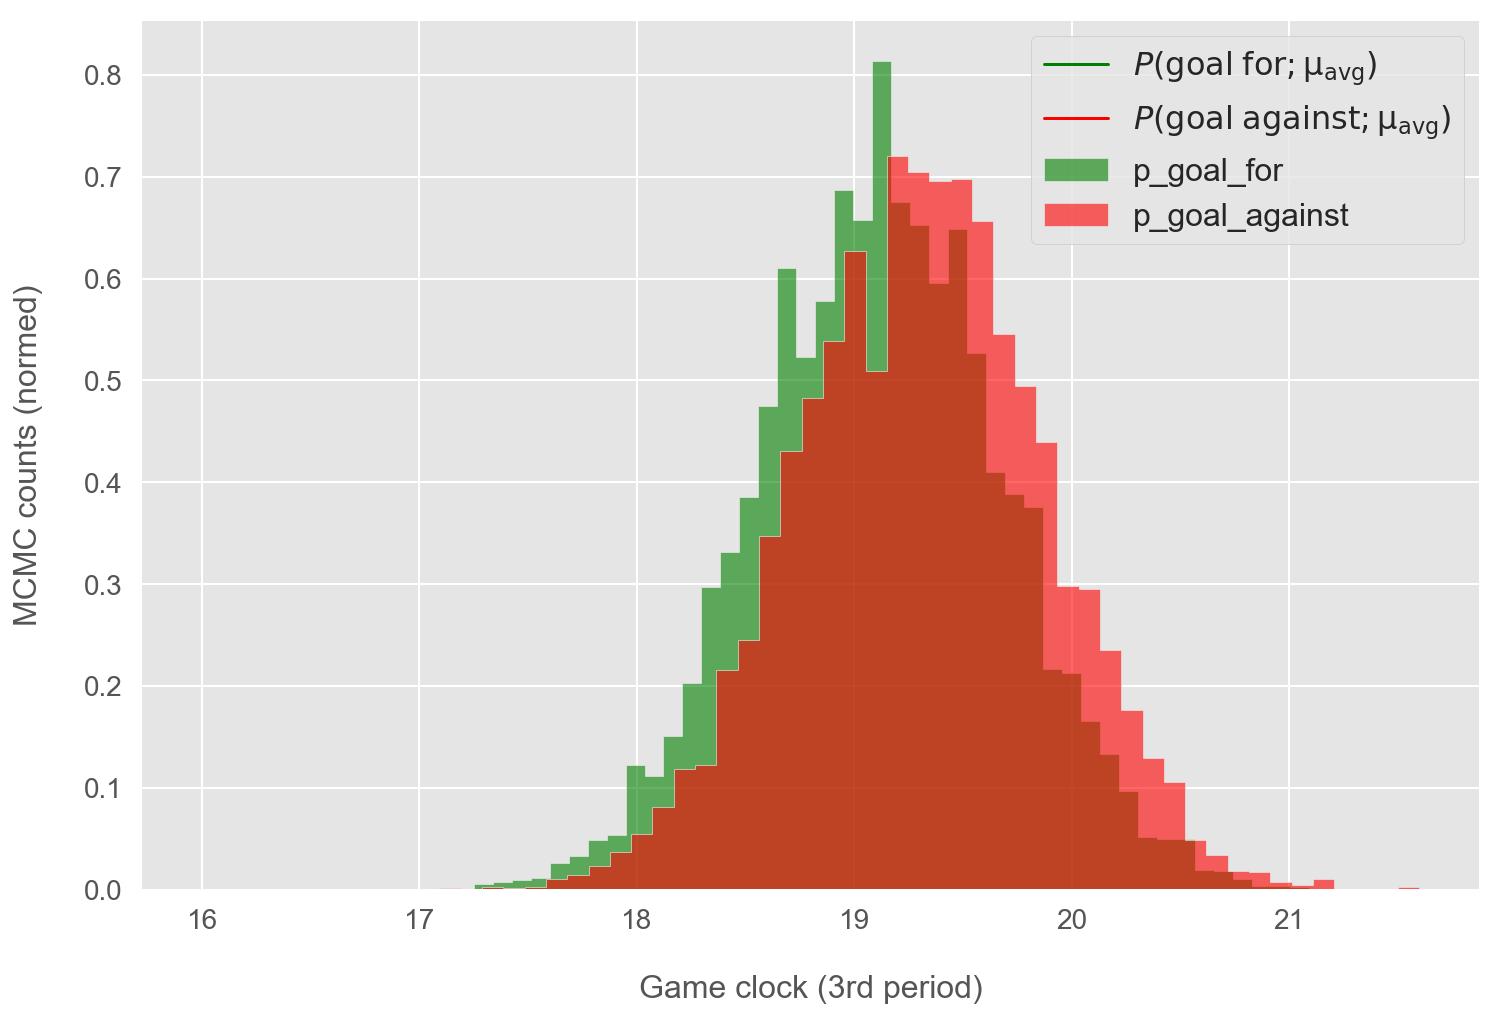

In [56]:
ALPHA = 0.6

# plt.hist(burned_trace['p_goal_for'] / 60, bins=50,
#          color='green', label=r'$P(\rm{goal\;for}\;|\;\rm{goalie\;pulled})$',
#          histtype='stepfilled', alpha=ALPHA)

# plt.hist(burned_trace['p_goal_against'] / 60, bins=50,
#          color='red', label=r'$P(\rm{goal\;against}\;|\;\rm{goalie\;pulled})$',
#          histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['p_goal_for'] / 60, bins=50,
         color='green', label='p_goal_for',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['p_goal_against'] / 60, bins=50,
         color='red', label='p_goal_against',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

poisson = lambda mu, k: mu**k * np.exp(-mu) / factorial(k)
x = np.arange(16, 22, 1)
mu_goal_for = burned_trace['mu_goal_for'].mean()
y_goal_for = poisson(mu_goal_for, x)
mu_goal_against = burned_trace['mu_goal_against'].mean()
y_goal_against = poisson(mu_goal_against, x)
plt.plot(x, y_goal_for, label=r'$P(\rm{goal\;for};\mu_{avg})$', color='green')
plt.plot(x, y_goal_against, label=r'$P(\rm{goal\;against};\mu_{avg})$', color='red')

plt.ylabel('MCMC counts (normed)')
plt.xlabel('Game clock (3rd period)')
plt.legend();

In [61]:
poisson = lambda mu, k: mu**k * np.exp(-mu) / factorial(k)
print(mu_goal_for)
print(poisson(mu_goal_for, k))

1147.357293070754
[0. 0. 0. 0. 0. 0.]


In [ ]:
factorial(k, exact=False)

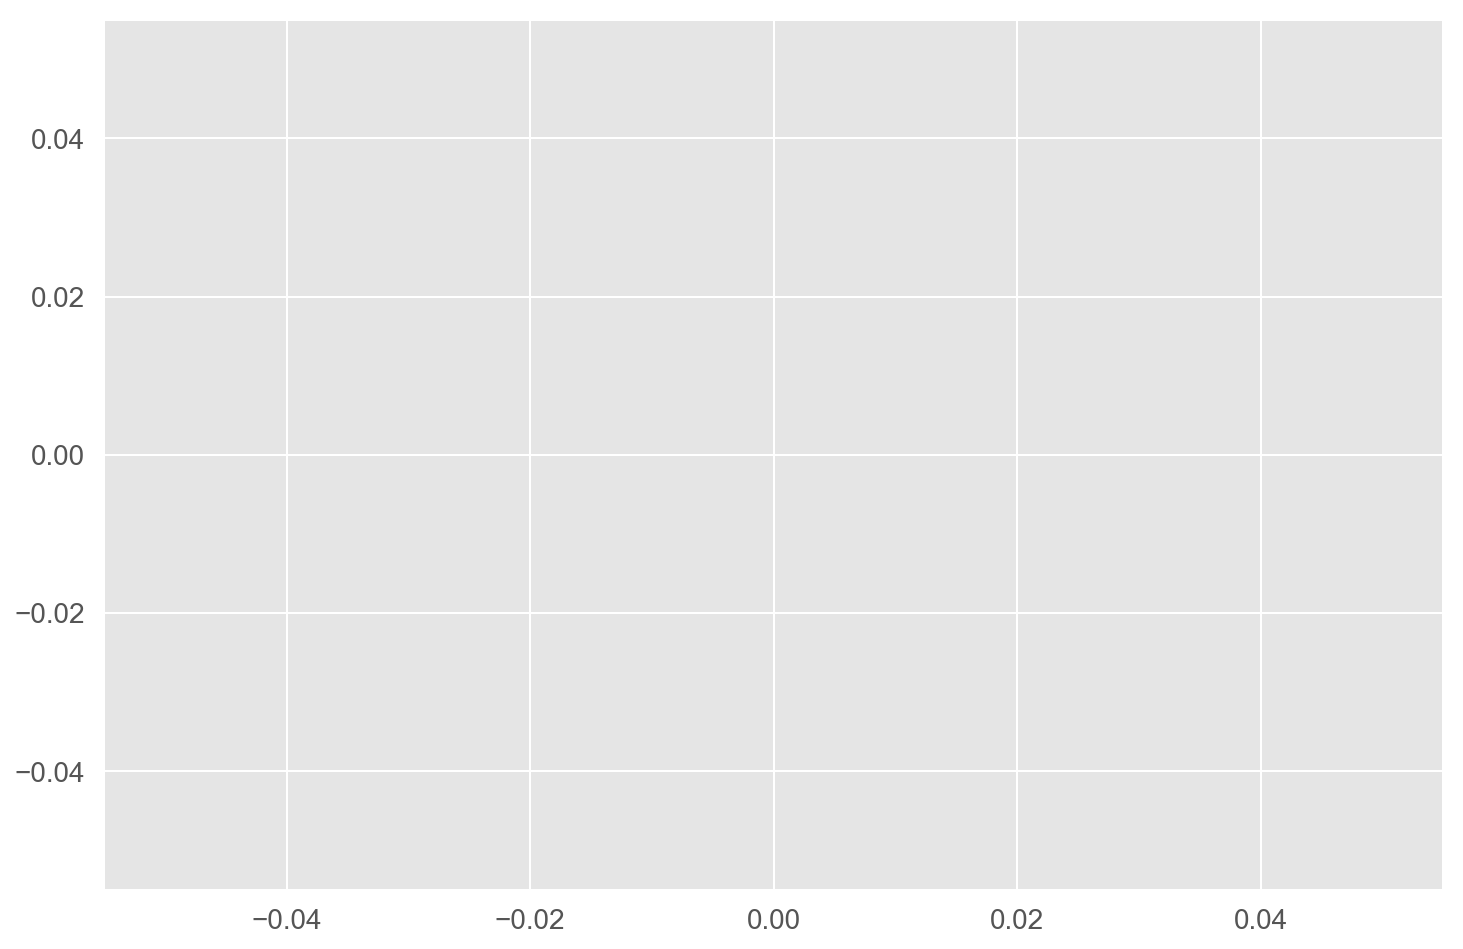

In [71]:
def poisson(mu, k):
    out = mu**k
    out = out * np.exp(-mu)
    out = out / factorial(k, exact=False)
    return out

# poisson = lambda mu, k: mu**k * np.exp(-mu) / factorial(k, exact=True)
k = np.arange(int(15*60), int(25*60), 1)

mu_goal_for = burned_trace['mu_goal_for'].mean()
y_goal_for = poisson(mu_goal_for, k)

mu_goal_against = burned_trace['mu_goal_against'].mean()
y_goal_against = poisson(mu_goal_against, k)

plt.plot(k, y_goal_for, label=r'$P(\rm{goal\;for};\mu_{avg})$', color='green')
plt.plot(k, y_goal_against, label=r'$P(\rm{goal\;against};\mu_{avg})$', color='red')

In [73]:
y_goal_for

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [9]:
from scipy.stats import gamma

In [64]:
gamma?

```
pdf(x, a, loc=0, scale=1)
    Probability density function.
```

So we would have 3 parameters to optimize here... `a, loc and scale`

In [10]:
x = np.arange(0, 20, 0.1)
y = [gamma.pdf(_x, 1, 1, 1)
     for _x in x]
plt.plot(x, y)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x118c7ba60> (for post_execute):


ValueError: Invalid RGBA argument: '348ABD'

ValueError: Invalid RGBA argument: '348ABD'

<Figure size 864x576 with 1 Axes>

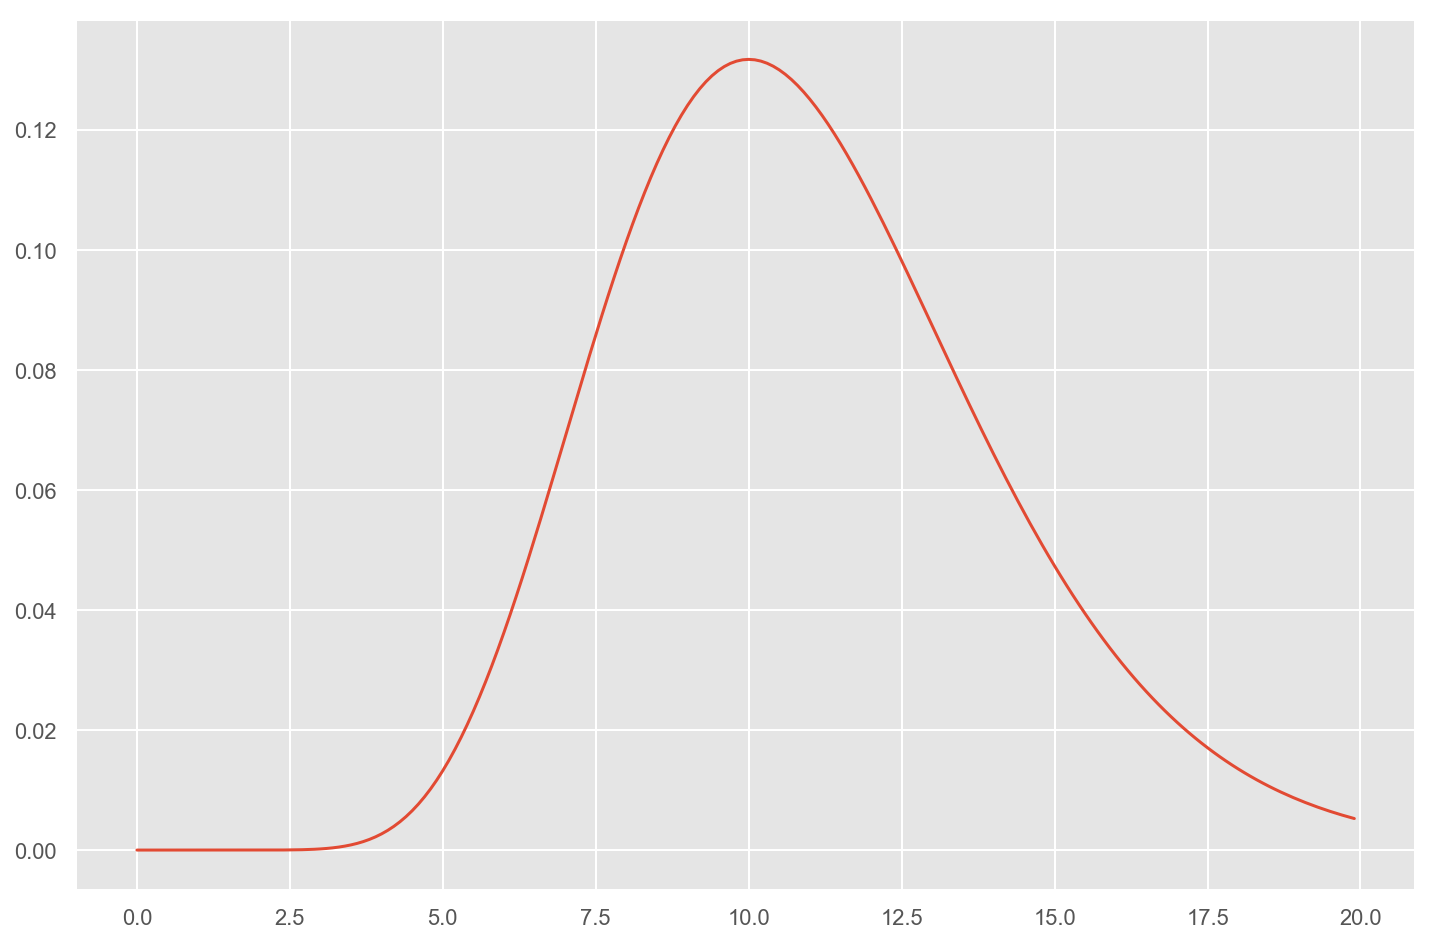

In [59]:
x = np.arange(0, 20, 0.1)
y = [gamma.pdf(_x, 10, 1, 1)
     for _x in x]
plt.plot(x, y)

What if we use a poisson instead? 

In [60]:
from scipy.stats import poisson

In [61]:
poisson?

```
pmf(k, mu, loc=0)   
    Probability mass function.
```

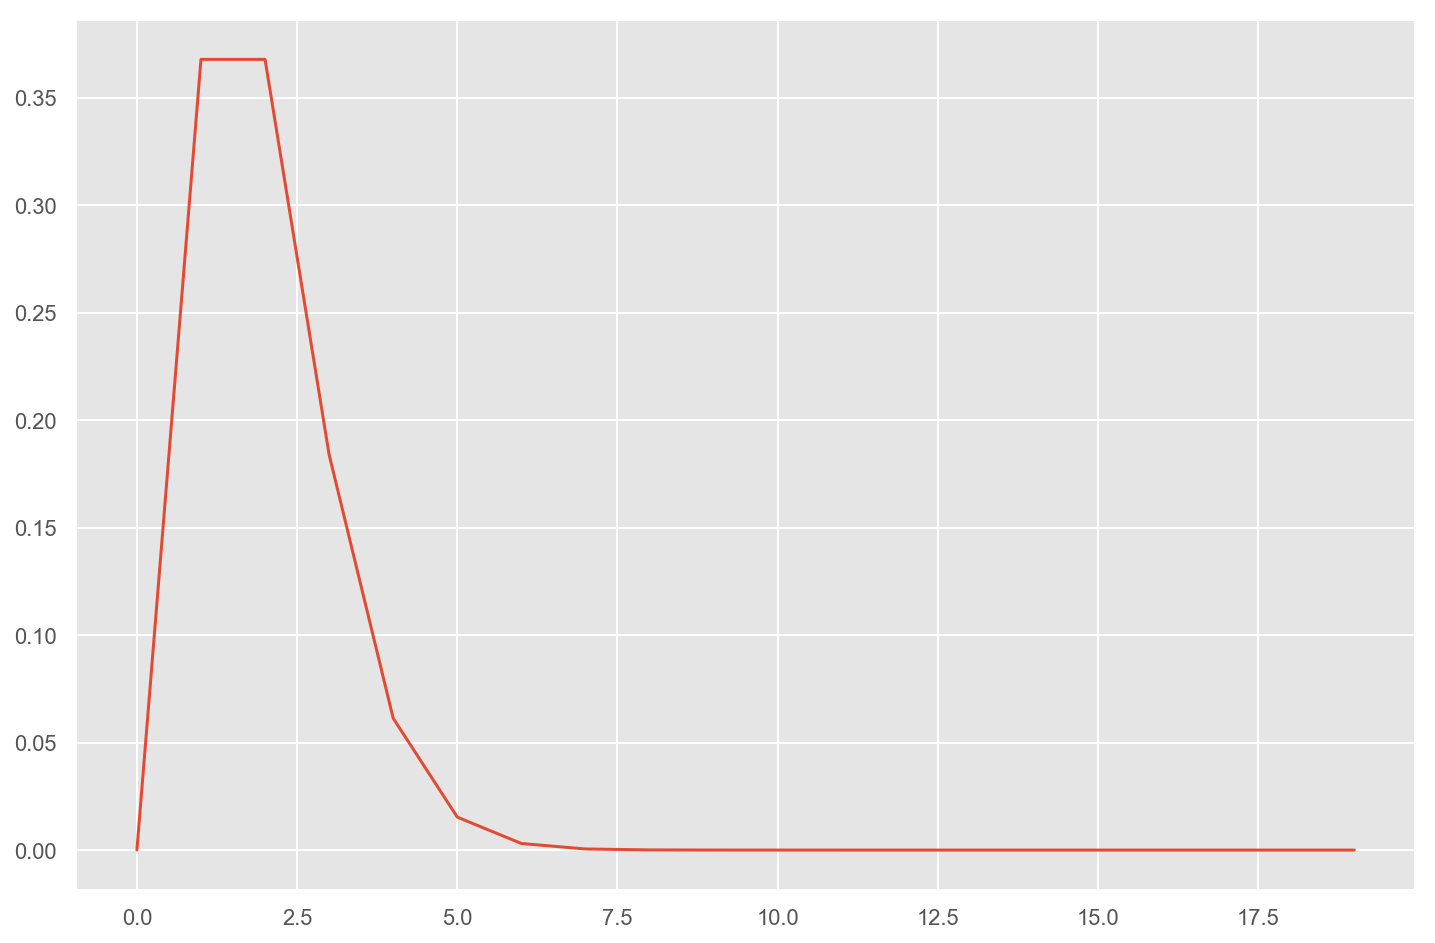

In [63]:
x = np.arange(0, 20, 1)
y = [poisson.pmf(_x, 1, 1)
     for _x in x]
plt.plot(x, y)